# Bài toán/Vấn đề cần giải quyết:
Việc giữ chân những khách hàng có tiềm năng mang lại lợi nhuận lớn là 1 trong những tiêu chí hàng đầu đối với nhiều ngân hàng. Hiện tượng gian lận trong giao dịch là mối nguy hiểm tiềm tàng cho nhiều ngân hàng. Điều này gây ảnh hưởng đáng kể về tiền bạc cũng như uy tín, lẫn cho ngân hàng và khách hàng.

Trong lĩnh vực ngân hàng, việc sử dụng học máy để phát hiện các trường hợp gian lận thẻ tín dụng không chỉ là 1 xu hướng mà còn là 1 giải pháp cần thiết để đối phó với tình trạng gian lận này. Áp dụng học máy giúp các ngân hàng hạn chế lãng phí thời gian, tiền bạc để kiểm tra tính hợp lệ của các giao dịch.

# Vài nét sơ qua về bộ dữ liệu được sử dụng:
Bộ dữ liệu này chứa dữ liệu về những giao dịch qua thẻ tín dụng (credit card) của những chủ thẻ ở Châu Âu trong khoảng thời gian 2 ngày trong tháng 9 năm 2013.

Có 492 lượt giao dịch là gian lận trong số 284,807 giao dịch được ghi lại.

Bộ dữ liệu này vô cùng bất cân bằng, số giao dịch gian lận chỉ chiếm 0.172% tổng số giao dịch.

Ngoài 'time' và 'amount', tất cả các thuộc tính còn lại đều đã được sửa đổi bằng PCA (Principal Component Analysis) để giữ bảo mật thông tin cho khách hàng.

**Giải thích các thuộc tính:**
* **'time':** khoảng thời gian giữa giao dịch đầu tiên và giao dịch liền kề
* **'amount':** số tiền giao dịch
* **'class':** thể hiện tính hợp lệ của giao dịch, 1 = gian lận và 0 = hợp lệ.

In [1]:
# Imported Libraries

import numpy as np # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.manifold import TSNE # type: ignore
from sklearn.decomposition import PCA, TruncatedSVD # type: ignore
import matplotlib.patches as mpatches # type: ignore
import time # type: ignore

# Classifier Libraries
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.tree import DecisionTreeClassifier # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
import collections # type: ignore


# Other Libraries
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.pipeline import make_pipeline # type: ignore
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore
from imblearn.under_sampling import NearMiss # type: ignore
from imblearn.metrics import classification_report_imbalanced # type: ignore
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report # type: ignore
from collections import Counter # type: ignore
from sklearn.model_selection import KFold, StratifiedKFold # type: ignore
import warnings # type: ignore
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
#Kiểm tra số lượng giá trị NULL
df.isnull().sum().max()

0

In [5]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

(284807, 31)

Dữ liệu gồm 31 thuộc tính, có 284807 giao dịch được ghi lại.

Các thuộc tính V1 -> V28 đã được PCA để bảo mật thông tin người dùng.

In [6]:
print('Giao dịch hợp lệ: ', round(df['Class'].value_counts()[0]/len(df) * 100,2), '%')
print('Giao dịch gian lận: ', round(df['Class'].value_counts()[1]/len(df) * 100,2), '%')

Giao dịch hợp lệ:  99.83 %
Giao dịch gian lận:  0.17 %


Có thể thấy rằng bộ dữ liệu được sử dụng có sự bất cân bằng giữa số giao dịch hợp lệ và gian lận. Hầu hết các giao dịch được ghi lại đều là những giao dịch hợp lệ.

Nếu sử dụng bộ dữ liệu này để xây dựng model sẽ gây ra nhiều lỗi và sẽ dễ xảy ra tình trạng overfitting do thuật toán sẽ cho rằng phần lớn giao dịch là hợp lệ. Nhưng chúng ta không muốn tình trạng đó xảy ra, chúng ta cần model phát hiện được dấu hiện của những giao dịch gian lận.

**Do đó chúng ta phải xử lý lại bộ dữ liệu này cho hợp lý.**

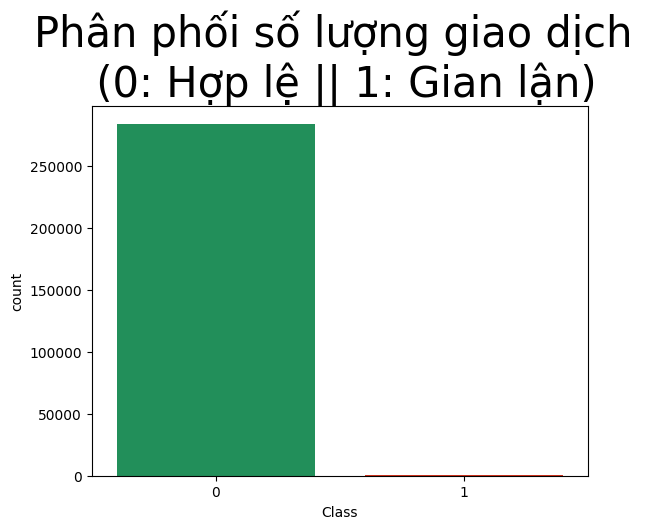

In [7]:
colors = ["#10A15A", "#F01C00"]

sns.countplot(x="Class", data=df, palette=colors)
plt.title("Phân phối số lượng giao dịch \n (0: Hợp lệ || 1: Gian lận)", fontsize=30)
plt.show()

Thể hiện rõ hơn sự chêch lệch, mất cân bằng giữa số giao dịch hợp lệ, gian lận trong bộ dữ liệu.

In [8]:
from sklearn.preprocessing import RobustScaler # type: ignore

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

Cần chuẩn hóa thuộc tính **time** và **amount** cho phù hợp với các thuộc tính khác.

RobustScaler ít bị ảnh hưởng bởi giá trị ngoại lai.

In [9]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)


df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Chia dữ liệu (Từ dữ liệu gốc)
Trước khi đi sâu vào áp dụng các kĩ thuật xử lý dữ liệu, cần phải chia bộ dữ liệu gốc thành 2 bộ dữ liệu con,1 dùng để **train model** và 1 dùng để **test model**

In [10]:
from sklearn.model_selection import StratifiedKFold # type: ignore

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [11]:
# Chuyển thành ma trận
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

#Ghi chú: Nếu cell này chạy lỗi, chạy cell trước đó rồi thử lại.

Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


Kiểm tra phân phối số lượng giao dịch hợp lý và gian lận ở 2 bộ dữ liệu vừa tách ra, đảm bảo giống với phân phối số lượng giao dịch ở bộ dữ liệu gốc.

# Tạo bộ dữ liệu con
Đối với vấn đề này, chúng ta sẽ tạo một bộ dữ liệu con từ bộ dữ liệu ban đầu.

Bộ dữ liệu con này là 1 dataframe với tỉ lệ 50/50 số lượng giao dịch hợp lệ và gian lận, nghĩa là bộ dữ liệu con này sẽ có số giao dịch hợp lệ bằng với số giao dịch gian lận.

**Việc này sẽ giúp tránh: **
* **Overfitting:** Bởi số giao dịch hợp lệ và gian lận bằng nhau, model sẽ có thể nhận biết giao dịch gian lận chính xác hơn.
* **Sai lầm trong nhận xét tương quan giữa các thuộc tính:** Dù ta không hiểu được các thuộc tính V đại diện cho thuộc tính gì, sẽ rất có ích khi ta hiểu được tác động của các thuộc tính này đối với kết quả (Hợp lệ - Gian lận). Nếu sử dụng bộ dữ liệu bất cân bằng thì sẽ khó nhận ra được sự tương quan này.

# Random Under-Sampling:
Lược bớt dữ liệu nhằm tạo ra bộ dữ liệu cân bằng, tránh hiện tượng overfitting.

**Các bước cần thực hiện:**
* Đầu tiên cần xác định mức độ bất cân bằng của dữ liệu.
* Sau khi đã xác định được mức độ bất cân bằng, giảm số lượng giao dịch hợp lệ xuống bằng với số lượng giao dịch gian lận.
* Cuối cùng, trộn bộ dữ liệu vừa tạo được để kiểm tra xem model có thể luôn giữ một độ chính xác nhất định mỗi lần ta thực hiện các thao tác trên hay không.

**Chú ý:** Vấn đề của **Random Under-Sampling** là ta chịu rủi ro model phân loại (**classification model**) có thể sẽ không cho ra kết quả chính xác bởi sẽ có sự mất mát dữ liệu lớn (**information loss**) (từ 284,315 **giao dịch hợp lệ** xuống còn 492 giao dịch) 

In [12]:
# Trộn dữ liệu trước khi tạo bộ dữ liệu con

df = df.sample(frac=1)

# Số giao dịch gian lận là 492 giao dịch
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Trộn bộ dữ liệu con vừa tạo
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
36845,-0.285754,-0.540244,-1.197318,1.669143,0.786722,0.672257,-0.121603,-0.178856,0.237961,0.513206,...,0.083615,0.245866,0.726597,-0.038279,0.233642,-0.269229,-0.335983,0.141768,0.205675,0
57615,-0.296793,-0.431279,-1.232804,2.244119,-1.703826,1.492536,-1.192985,-1.686110,-1.864612,0.856122,...,0.207889,0.560475,0.165682,-0.013754,0.474935,-0.218725,0.302809,0.466031,0.250134,1
1488,5.428492,-0.981344,0.735662,-2.178314,0.297671,-1.023647,-2.015240,-0.752537,-0.477906,-0.340175,...,0.552575,-0.116226,-0.833963,-0.184237,0.370845,0.021512,-0.455393,-0.025080,0.101168,0
30314,-0.201076,-0.573620,-2.044489,3.368306,-3.937111,5.623120,-3.079232,-1.253474,-5.778880,1.707428,...,1.112028,1.483594,0.834311,-0.148486,0.001669,-0.038996,0.389526,1.300236,0.549940,1
15566,1.089779,-0.678239,-23.237920,13.487386,-25.188773,6.261733,-17.345188,-4.534989,-17.100492,15.374630,...,1.630787,1.769708,-1.691973,-1.045673,0.143386,1.611577,-0.221576,1.481233,0.438125,1


Giờ chúng ta đã có 1 dataframe cân bằng, ta có thể đi sâu hơn vào phân tích (**analysis**) và tiền xử lí dữ liệu (**data preprocessing**)

Phân phối số lượng giao dịch trong bộ dữ liệu con vừa tạo
Class
0    0.5
1    0.5
Name: count, dtype: float64


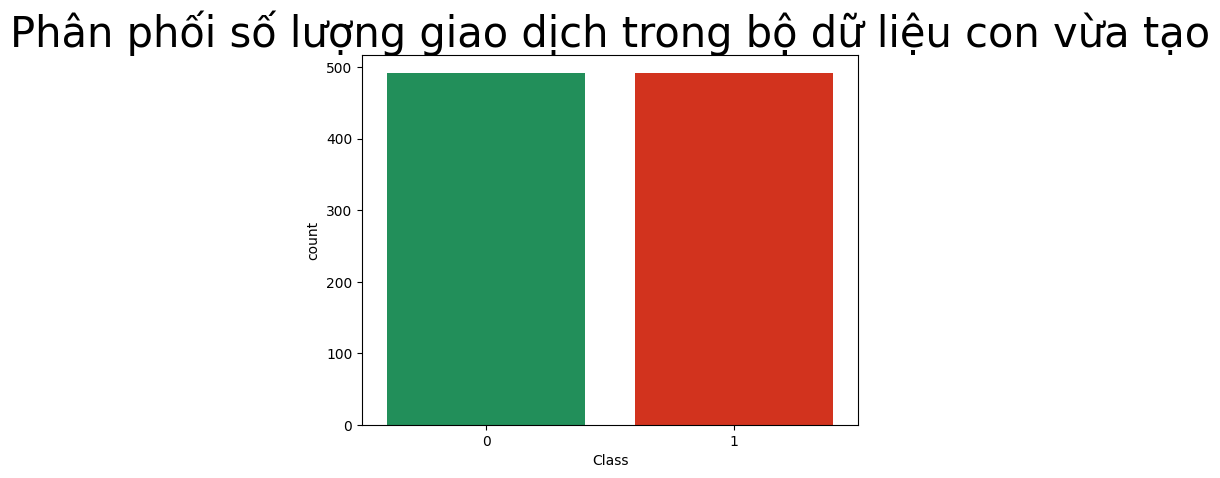

In [13]:
print('Phân phối số lượng giao dịch trong bộ dữ liệu con vừa tạo')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Phân phối số lượng giao dịch trong bộ dữ liệu con vừa tạo', fontsize=30)
plt.show()

**Phân tích - Analysis**

**Ma trận tương quan - Correlation Matrix**
Là 1 công cụ cực kì quan trọng để hiểu về dữ liệu. Chúng ta muốn biết những thuộc tính nào sẽ có ảnh hưởng lớn đến việc xác định xem 1 giao dịch có được xem là gian lận hay không.

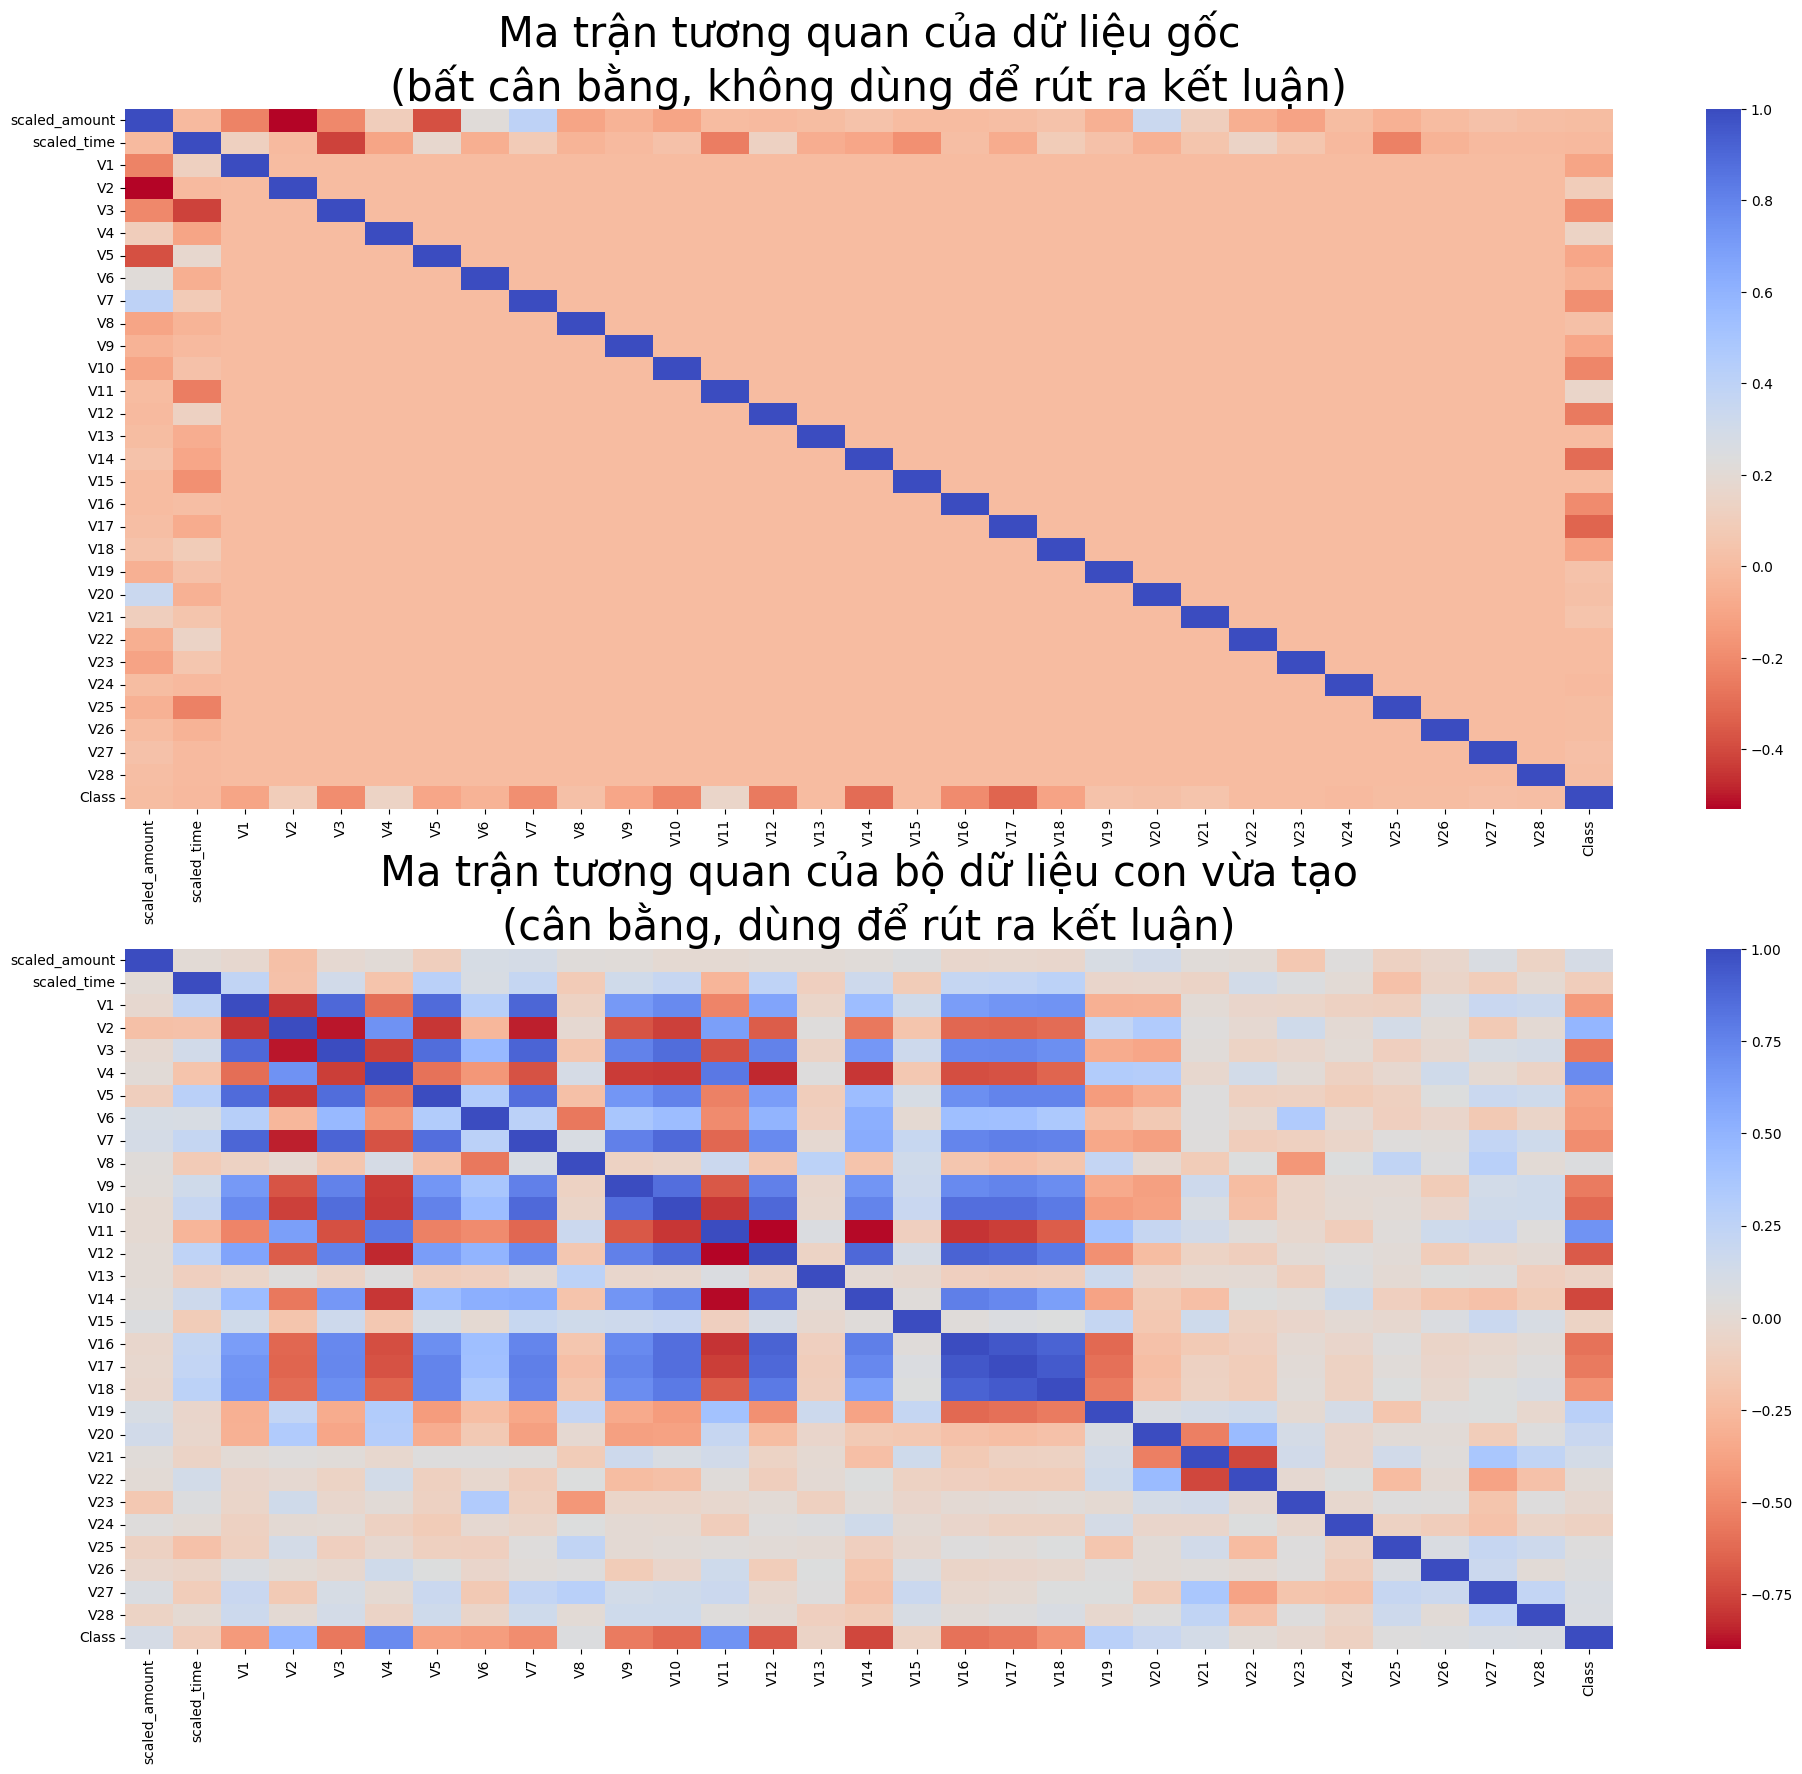

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

#Dữ liệu gốc
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Ma trận tương quan của dữ liệu gốc\n(bất cân bằng, không dùng để rút ra kết luận)", fontsize=30)

#Bộ dữ liệu con vừa tạo
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Ma trận tương quan của bộ dữ liệu con vừa tạo\n(cân bằng, dùng để rút ra kết luận)', fontsize=30)
plt.show()

**Kết luận:**
* **Quan hệ nghịch biến - Tương quan âm (Negative Corelations):** V17, V14, V12 và V10 tương quan âm. Những giao dịch có giá trị thuộc tính này càng thấp thì khả năng là giao dịch gian lận càng cao.
* **Quan hệ đồng biến - Tương quan dương (Positive Correlations):** V2, V4, V11 và V19 tương quan dương. Những giao dịch có giá trị thuộc tính này càng cao thì khả năng là giao dịch gian lận càng cao.

Tiếp tục vẽ boxplot để có thể hiểu rõ những thuộc tính trên được phân phối như thế nào đối với giao dịch hợp lệ và gian lận.

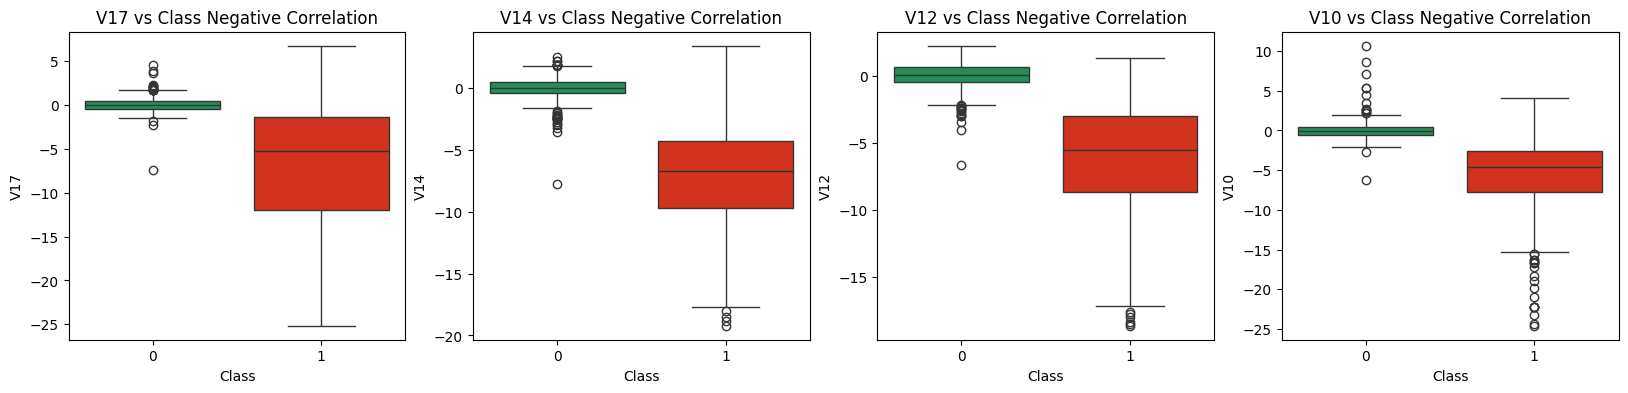

In [15]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Tương quan âm (Giá trị càng nhỏ thì khả năng là giao dịch gian lận càng lớn
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

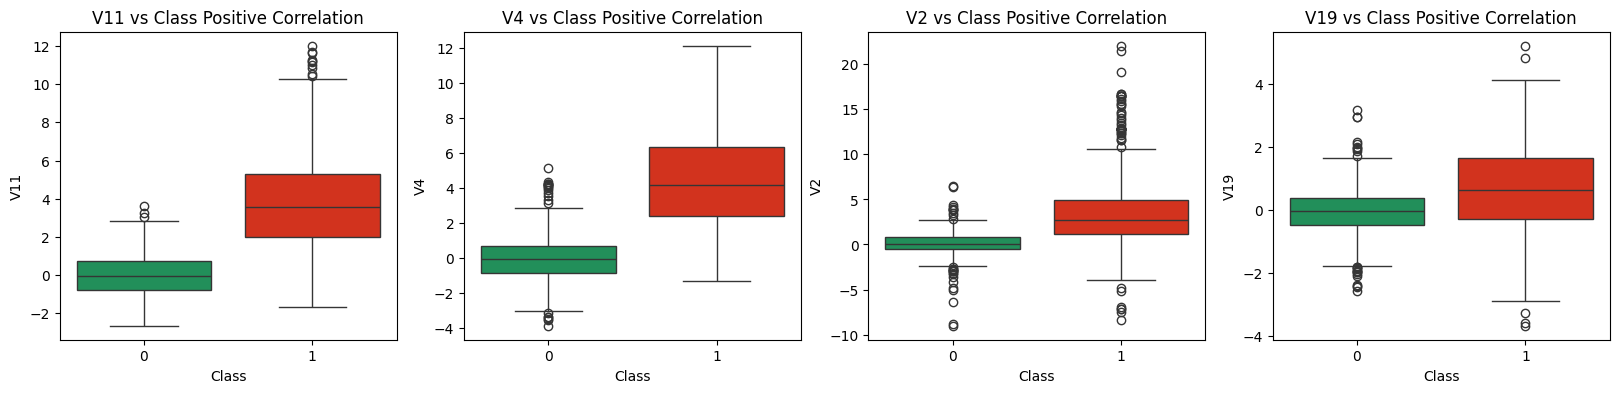

In [16]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Tương quan dương (Giá trị càng lớn thì khả năng là giao dịch gian lận càng cao) 
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

# Phát hiện những giá trị bất thường - Anomaly Detection
# PP1: Phương pháp khoảng tứ phân vị
Mục đích của phần này là loại bỏ đi những giá trị ngoại lai có thể làm sai lệch về dữ liệu của các thuộc tính có tính tương quan cao đối với việc xác định tính hợp lệ của giao dịch. Điều này sẽ nâng cao độ chính xác cho model của ta.

Phương pháp khoảng tứ phân vị - Interquartile Range Method:
Khoảng tứ phân vị - Interquartile Range (IQR): Khoảng này được xác định bởi đoạn từ 75% đến 25% của phân phối dữ liệu. Mục đích của chúng ta là tạo ra một khoảng giới hạn giá trị mà tại đó nếu giá trị nào vượt khỏi khoảng giá trị thì sẽ bị loại bỏ.

Đánh đổi khi loại bỏ giá trị ngoại lai:
Cần phải cẩn trọng đối với việc xác định khoảng giới hạn giá trị. Khoảng giá trị được xác định bằng cách nhân một số với khoảng tứ phân vị. Khoảng giới hạn càng lớn, càng ít giá trị ngoại lai bị  loại bỏ và ngược lại, khoảng giá trị càng nhỏ, càng nhiều giá trị ngoại lai bị loại bỏ.

Đánh đổi:
Khoảng giá trị giới hạn càng nhỏ, càng nhiều giá trị ngoại lai bị loại bỏ, nhưng ta chỉ nên tập trung loại bỏ những giá trị ngoại lai có thể làm sai lệch về dữ liệu. Bởi việc loại bỏ quá nhiều giá trị ngoại lai sẽ gây ra sự mất mát dữ liệu lớn, ảnh hưởng đến độ chính xác của model.

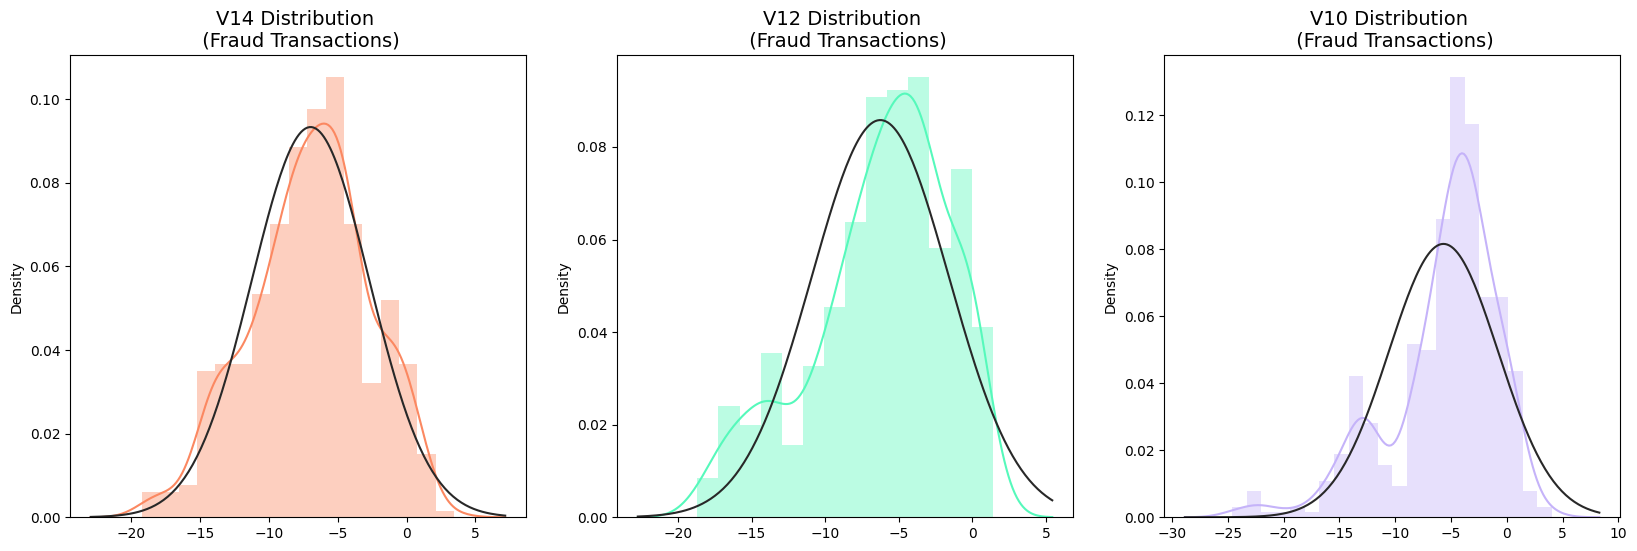

In [17]:
from scipy.stats import norm # type: ignore

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

Có thể thấy rằng chỉ V14 có phân phối chuẩn.

Loại bỏ những giá trị ngoại lai gây sai lệch về dữ liệu sau khi đã xác định khoảng giá trị giới hạn. Ở đây ta nhân khoảng tứ phân vị với 1.5, giới hạn dưới bằng với giá trị phân vị 25% trừ cho kết quả vừa tìm được, giới hạn trên bằng với giá trị phân vị 75% cộng cho kết quả trên.

Sau đó dựa theo khoảng giá trị giới hạn vừa tìm được để loại bỏ những giá trị ngoại lai nằm ngoài giới hạn đó.

In [18]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
new_df.head()

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.0499976898594, -18.8220867423816, -18.4937733551053, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.0475965708216, -18.6837146333443, -18.5536970096458, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-17.1415136412892, -22.187088

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
36845,-0.285754,-0.540244,-1.197318,1.669143,0.786722,0.672257,-0.121603,-0.178856,0.237961,0.513206,...,0.083615,0.245866,0.726597,-0.038279,0.233642,-0.269229,-0.335983,0.141768,0.205675,0
57615,-0.296793,-0.431279,-1.232804,2.244119,-1.703826,1.492536,-1.192985,-1.686110,-1.864612,0.856122,...,0.207889,0.560475,0.165682,-0.013754,0.474935,-0.218725,0.302809,0.466031,0.250134,1
1488,5.428492,-0.981344,0.735662,-2.178314,0.297671,-1.023647,-2.015240,-0.752537,-0.477906,-0.340175,...,0.552575,-0.116226,-0.833963,-0.184237,0.370845,0.021512,-0.455393,-0.025080,0.101168,0
30314,-0.201076,-0.573620,-2.044489,3.368306,-3.937111,5.623120,-3.079232,-1.253474,-5.778880,1.707428,...,1.112028,1.483594,0.834311,-0.148486,0.001669,-0.038996,0.389526,1.300236,0.549940,1
15566,1.089779,-0.678239,-23.237920,13.487386,-25.188773,6.261733,-17.345188,-4.534989,-17.100492,15.374630,...,1.630787,1.769708,-1.691973,-1.045673,0.143386,1.611577,-0.221576,1.481233,0.438125,1


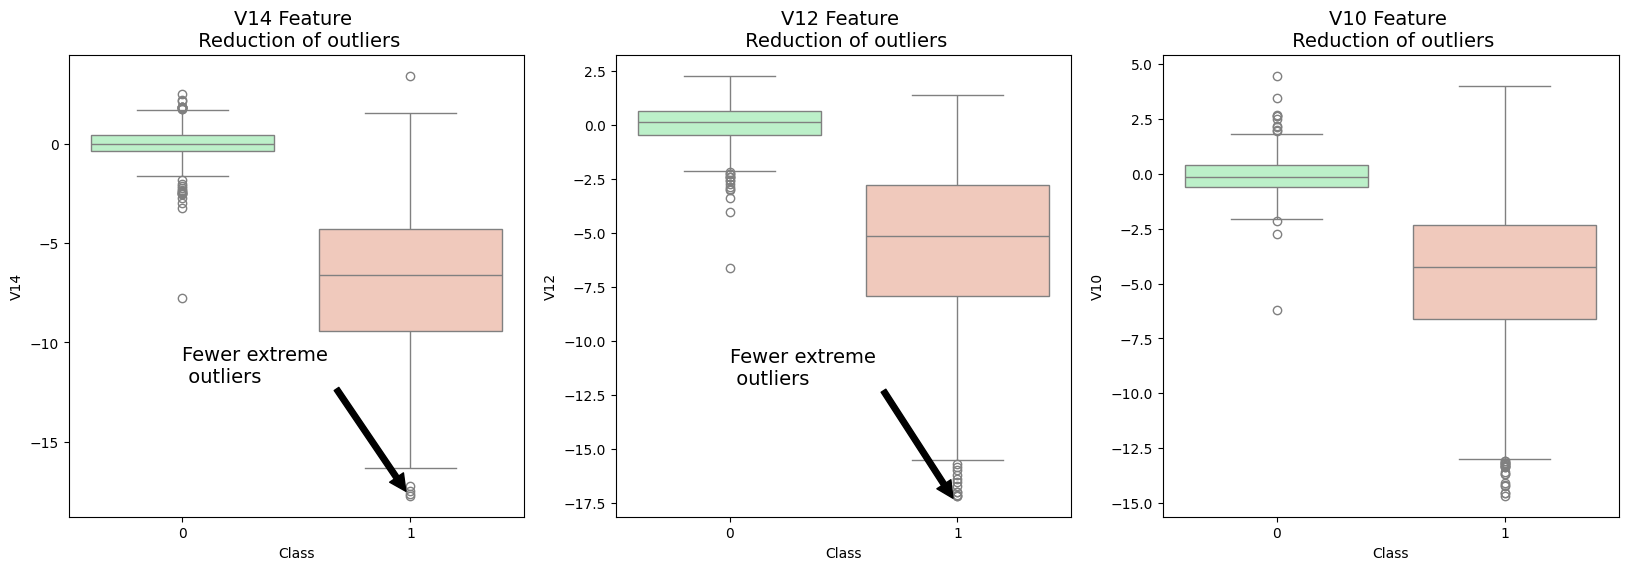

In [19]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

# PP2: Phương pháp độ lệch chuẩn(standard deviation method)


In [20]:
new_df2 = new_df.copy()  #thêm new_df2 để tránh ghi đè lên new_df

# -----> V14 Removing Outliers using Standard Deviation Method
v14_fraud = new_df2['V14'].loc[new_df2['Class'] == 1].values
mean_v14 = np.mean(v14_fraud)
std_v14 = np.std(v14_fraud)
print('Mean: {} | Standard Deviation: {}'.format(mean_v14, std_v14))

v14_cut_off = std_v14 * 3
v14_lower, v14_upper = mean_v14 - v14_cut_off, mean_v14 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers_v14 = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers_v14)))
print('V14 outliers: {}'.format(outliers_v14))

new_df2 = new_df2.drop(new_df2[(new_df2['V14'] > v14_upper) | (new_df2['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers using Standard Deviation Method
v12_fraud = new_df2['V12'].loc[new_df2['Class'] == 1].values
mean_v12 = np.mean(v12_fraud)
std_v12 = np.std(v12_fraud)
print('Mean: {} | Standard Deviation: {}'.format(mean_v12, std_v12))

v12_cut_off = std_v12 * 3
v12_lower, v12_upper = mean_v12 - v12_cut_off, mean_v12 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))

outliers_v12 = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers_v12))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers_v12)))

new_df2 = new_df2.drop(new_df2[(new_df2['V12'] > v12_upper) | (new_df2['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df2)))
print('----' * 44)

# Removing outliers V10 Feature using Standard Deviation Method
v10_fraud = new_df2['V10'].loc[new_df2['Class'] == 1].values
mean_v10 = np.mean(v10_fraud)
std_v10 = np.std(v10_fraud)
print('Mean: {} | Standard Deviation: {}'.format(mean_v10, std_v10))

v10_cut_off = std_v10 * 3
v10_lower, v10_upper = mean_v10 - v10_cut_off, mean_v10 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))

outliers_v10 = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers_v10))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers_v10)))

new_df2 = new_df2.drop(new_df2[(new_df2['V10'] > v10_upper) | (new_df2['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df2)))


Mean: -6.756202653587614 | Standard Deviation: 4.053270886557962
Cut Off: 12.159812659673886
V14 Lower: -18.9160153132615
V14 Upper: 5.4036100060862715
Feature V14 Outliers for Fraud Cases: 0
V14 outliers: []
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mean: -5.666290535972832 | Standard Deviation: 4.198904019387771
V12 Lower: -18.263002594136147
V12 Upper: 6.93042152219048
V12 outliers: []
Feature V12 Outliers for Fraud Cases: 0
Number of Instances after outliers removal: 944
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mean: -4.820820462551533 | Standard Deviation: 3.7918761500909453
V10 Lower: -16.19644891282437
V10 Upper: 6.5548079877213015
V10 outliers: []
Feature V10 Outliers for Fraud Cases: 0
Number of Instances after

# Giảm chiều - Phân cụm dữ liệu (Dimension Reduction - Clustering)
**Xét 3 thuật toán phân cụm:**
* t-SNE
* PCA
* Truncated SVD

In [21]:
from sklearn.manifold import TSNE # type: ignore
from sklearn.decomposition import PCA, TruncatedSVD # type: ignore
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# t-SNE
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# Truncated SVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 8.8 s
PCA took 0.0023 s
Truncated SVD took 0.003 s


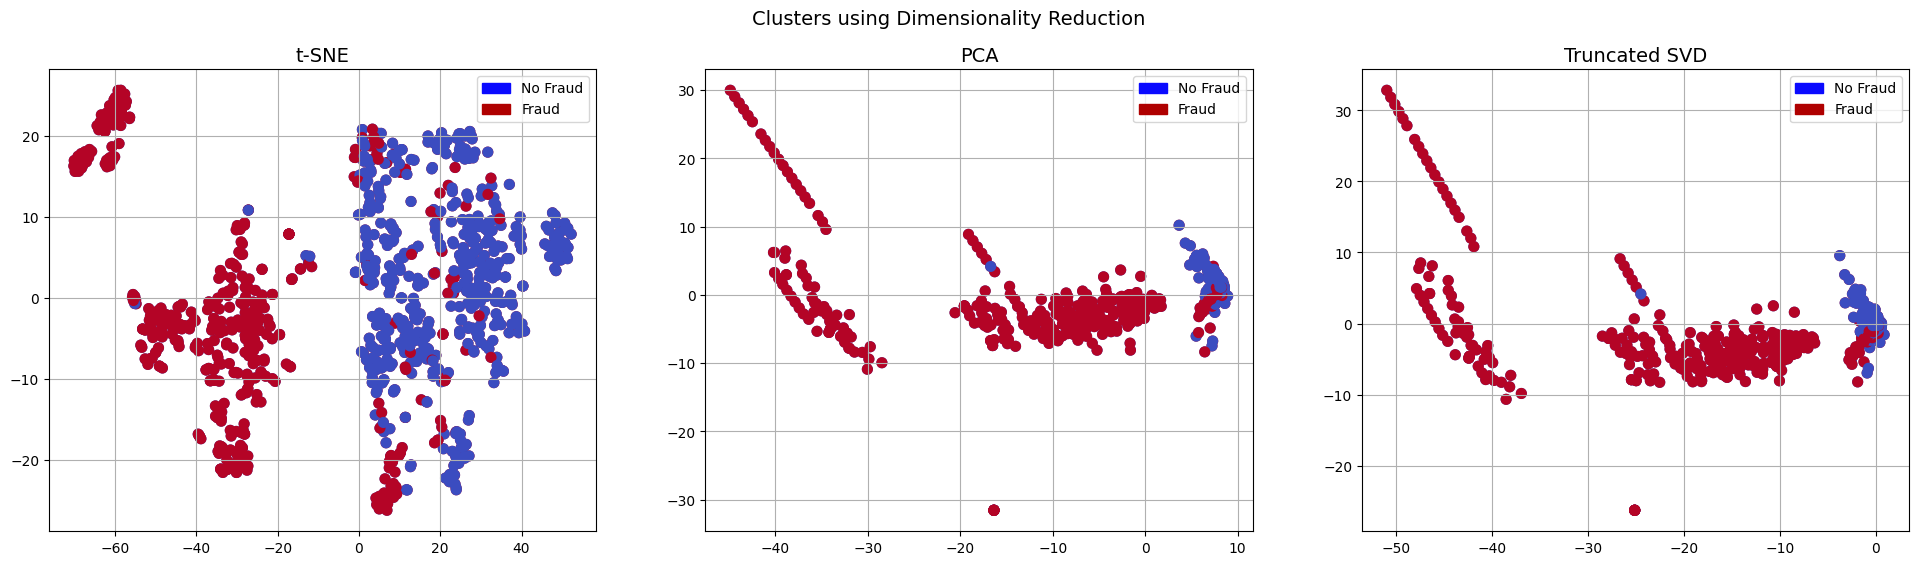

In [22]:
import matplotlib.patches as mpatches # type: ignore

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

Thuật toán t-SNE phân cụm giữa giao dịch hợp lệ và gian lận khá tốt.

# Chọn và Train Model
Chúng ta sẽ train 6 thuật toán phân loại (**classifier**) và chọn ra bộ phân loại mang lại độ hiệu quả cao nhất đối với việc phát hiện giao dịch gian lận.
* Logistic Regression
* KNeighbors Classifier
* SVC
* Decision Tree Classifier
* Random Forest Classifier
* XGBoost Classifier

In [23]:
#Tách dữ liệu thành 2 phần, để train và test
from sklearn.model_selection import train_test_split # type: ignore
target_col = ["Class"]
cols = [i for i in new_df.columns if i not in target_col]
X_train, X_test, y_train, y_test = train_test_split(new_df[cols], new_df[target_col], test_size=0.2, random_state=42)

In [24]:
#Chuyển thành ma trận

# X_train = X_train.values
# X_test = X_test.values
# y_train = y_train.values
# y_test = y_test.values

In [25]:
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.tree import DecisionTreeClassifier # type: ignore
from sklearn.ensemble import RandomForestClassifier #type: ignore
from xgboost import XGBClassifier # type: ignore

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

In [26]:
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import plotly.graph_objs as go # type: ignore
from plotly.subplots import make_subplots # type: ignore
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve # type: ignore
from yellowbrick.classifier import DiscriminationThreshold  # type: ignore # Cần cài đặt Yellowbrick để sử dụng DiscriminationThreshold

def fraud_detection_model_evaluation(algorithm, training_x, testing_x, training_y, testing_y, cf='None', threshold_plot=False):
    # Huấn luyện mô hình
    algorithm.fit(training_x, training_y)
    
    # Dự đoán và xác suất dự đoán
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)[:, 1]  # Lấy xác suất cho lớp dương
    
    # In thông tin về mô hình
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    # Tính và in ma trận nhầm lẫn
    conf_matrix = confusion_matrix(testing_y, predictions)
    print("\nConfusion Matrix:\n", conf_matrix)
    
    # Tính và in diện tích dưới đường cong ROC
    model_roc_auc = roc_auc_score(testing_y, probabilities) 
    print("\nArea under curve:", model_roc_auc,"\n")
    
    # Tính và vẽ đường cong ROC
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities)
    
    # Plot confusion matrix
    trace1 = go.Heatmap(z=conf_matrix,
                        x=["Not Fraud", "Fraud"],
                        y=["Not Fraud", "Fraud"],
                        showscale=False, colorscale="Picnic",
                        name="Confusion matrix")
    
    # Plot ROC curve
    trace2 = go.Scatter(x=fpr, y=tpr,
                        name="ROC Curve (AUC = %0.2f)" % model_roc_auc,
                        line=dict(color='rgb(22, 96, 167)', width=2))
    trace3 = go.Scatter(x=[0, 1], y=[0, 1],
                        line=dict(color='rgb(205, 12, 24)', width=2, dash='dot'))
    
    # Plot coefficients or features if requested
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = pd.merge(coefficients, column_df, left_index=True, right_index=True, how="left")
        coef_sumry.columns = ["Coefficients", "Features"]
        coef_sumry = coef_sumry.sort_values(by="Coefficients", ascending=False)
        
        # Plot coefficients
        trace4 = go.Bar(x=coef_sumry["Features"], y=coef_sumry["Coefficients"], 
                        name="Coefficients",
                        marker=dict(color=coef_sumry["Coefficients"],
                                    colorscale="Picnic",
                                    line=dict(width=0.6, color="black")))
        
        # Create subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver Operating Characteristic',
                                            'Feature Importances'))
        
        fig.add_trace(trace1, 1, 1)
        fig.add_trace(trace2, 1, 2)
        fig.add_trace(trace3, 1, 2)
        fig.add_trace(trace4, 2, 1)
        
        fig.update_layout(showlegend=False, title="Model Performance",
                          autosize=False, height=900, width=800,
                          plot_bgcolor='rgba(240, 240, 240, 0.95)',
                          paper_bgcolor='rgba(240, 240, 240, 0.95)',
                          margin=dict(b=195))
        
        fig.update_xaxes(title_text="False Positive Rate", row=2, col=2)
        fig.update_yaxes(title_text="True Positive Rate", row=2, col=2)
        fig.update_xaxes(showgrid=True, tickfont=dict(size=10), tickangle=90, row=2, col=1)
    
    elif cf == 'None':
        # Create subplots without coefficients or features
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=('Confusion Matrix',
                                            'Receiver Operating Characteristic'))
        
        fig.add_trace(trace1, 1, 1)
        fig.add_trace(trace2, 1, 2)
        fig.add_trace(trace3, 1, 2)
        
        fig.update_layout(showlegend=False, title="Model Performance",
                          autosize=False, height=500, width=800,
                          plot_bgcolor='rgba(240, 240, 240, 0.95)',
                          paper_bgcolor='rgba(240, 240, 240, 0.95)',
                          margin=dict(b=195))
        
        fig.update_xaxes(title_text="False Positive Rate", row=1, col=2)
        fig.update_yaxes(title_text="True Positive Rate", row=1, col=2)
    
    # Plotly chart display
    fig.show()
    
    # Visualize Discrimination Threshold if required
    if threshold_plot:
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x, training_y)
        visualizer.poof()


# Logistic Regession

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        92
           1       0.98      0.95      0.96        97

    accuracy                           0.96       189
   macro avg       0.96      0.96      0.96       189
weighted avg       0.96      0.96      0.96       189

Accuracy Score: 0.9629629629629629

Confusion Matrix:
 [[90  2]
 [ 5 92]]

Area under curve: 0.9936127297176154 



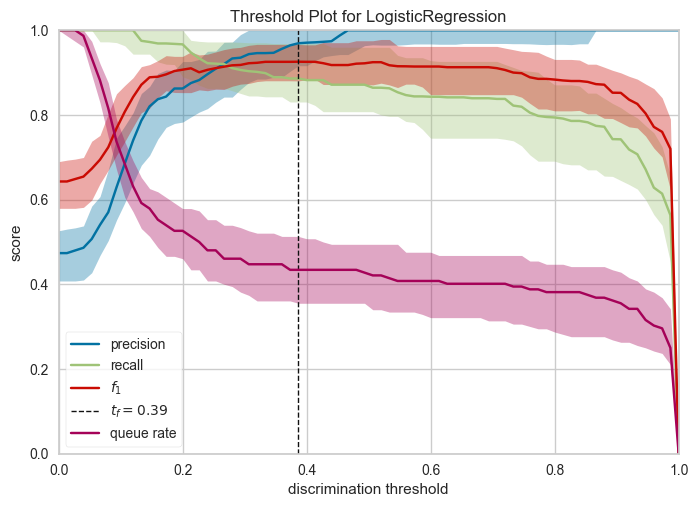

In [27]:
logit1 = LogisticRegression(C=0.01)

fraud_detection_model_evaluation(logit1, X_train, X_test, y_train, y_test, "coefficients", threshold_plot=True)

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95        92
           1       0.95      0.96      0.95        97

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

Accuracy Score: 0.9523809523809523

Confusion Matrix:
 [[87  5]
 [ 4 93]]

Area under curve: 0.9870013446884806 



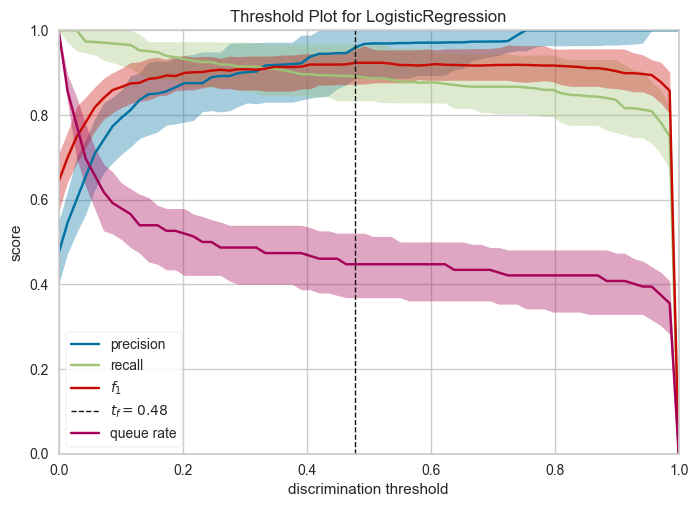

In [28]:
logit2 = LogisticRegression(C=1)

fraud_detection_model_evaluation(logit2, X_train, X_test, y_train, y_test, "coefficients", threshold_plot=True)

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95        92
           1       0.95      0.96      0.95        97

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

Accuracy Score: 0.9523809523809523

Confusion Matrix:
 [[87  5]
 [ 4 93]]

Area under curve: 0.9858807709547288 



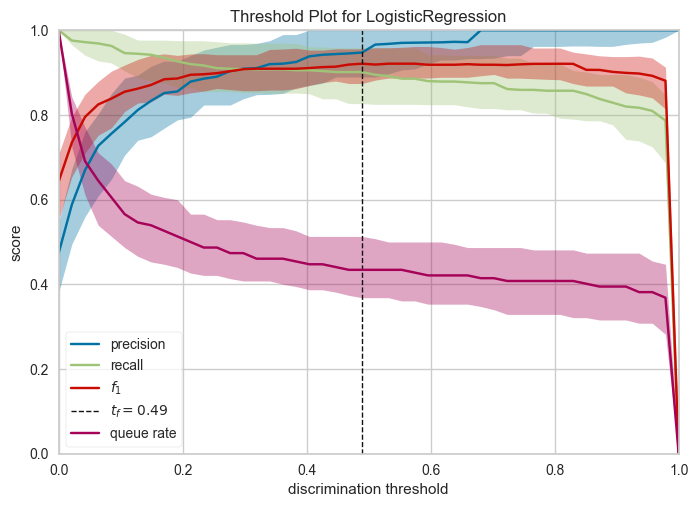

In [29]:
logit3 = LogisticRegression(C=100)

fraud_detection_model_evaluation(logit3, X_train, X_test, y_train, y_test, "coefficients", threshold_plot=True)

# KNeighbor Classifier

Algorithm: KNeighborsClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93        92
           1       0.92      0.95      0.93        97

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg       0.93      0.93      0.93       189

Accuracy Score: 0.9312169312169312

Confusion Matrix:
 [[84  8]
 [ 5 92]]

Area under curve: 0.9307485432541461 



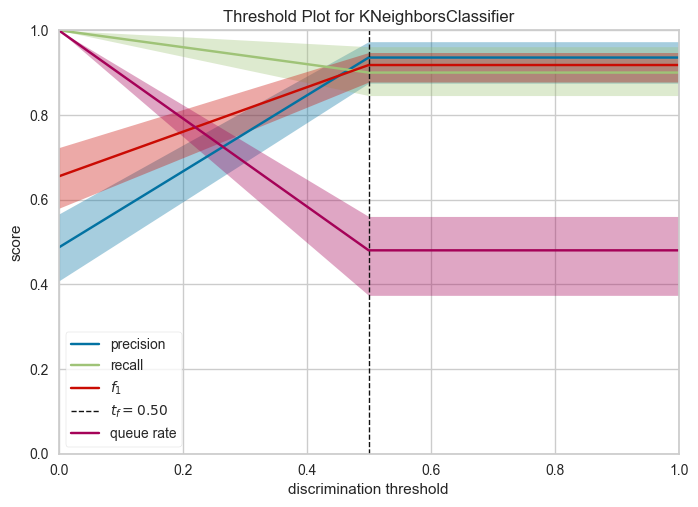

In [30]:
knn1 = KNeighborsClassifier(n_neighbors=1)
fraud_detection_model_evaluation(knn1, X_train, X_test, y_train, y_test, "None", threshold_plot=True)

Algorithm: KNeighborsClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        92
           1       0.95      0.95      0.95        97

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

Accuracy Score: 0.9470899470899471

Confusion Matrix:
 [[87  5]
 [ 5 92]]

Area under curve: 0.9876736889287315 



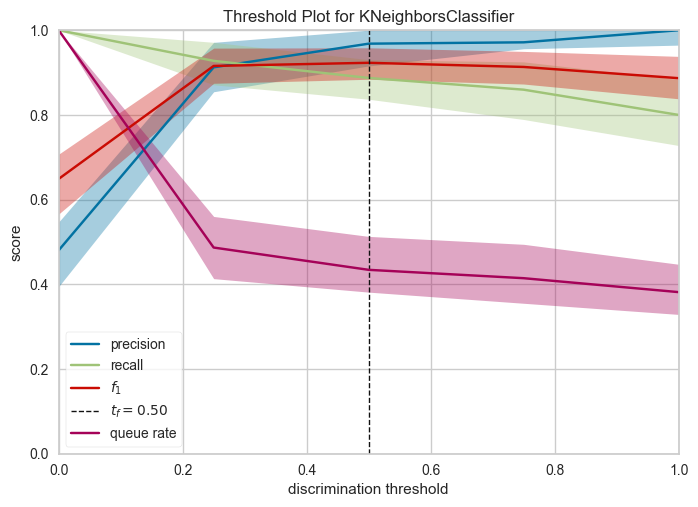

In [31]:
knn2 = KNeighborsClassifier(n_neighbors=5)
fraud_detection_model_evaluation(knn2, X_train, X_test, y_train, y_test, "None", threshold_plot=True)

Algorithm: KNeighborsClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95        92
           1       0.99      0.92      0.95        97

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

Accuracy Score: 0.9523809523809523

Confusion Matrix:
 [[91  1]
 [ 8 89]]

Area under curve: 0.9862169430748544 



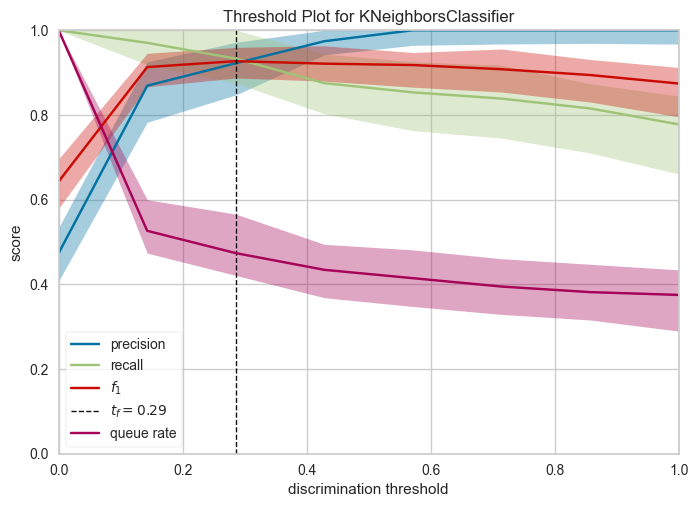

In [32]:
knn3 = KNeighborsClassifier(n_neighbors=10)
fraud_detection_model_evaluation(knn3, X_train, X_test, y_train, y_test, "None", threshold_plot=True)

# SVC

Algorithm: SVC

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        92
           1       0.97      0.95      0.96        97

    accuracy                           0.96       189
   macro avg       0.96      0.96      0.96       189
weighted avg       0.96      0.96      0.96       189

Accuracy Score: 0.9576719576719577

Confusion Matrix:
 [[89  3]
 [ 5 92]]

Area under curve: 0.9896907216494846 



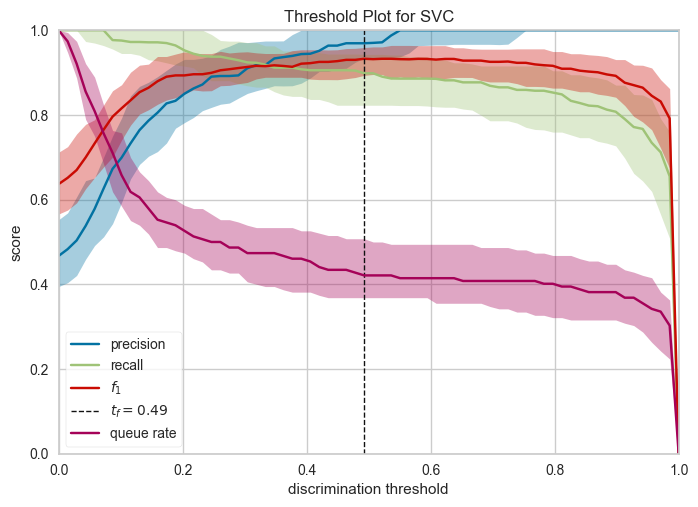

In [33]:
svc_lin1  = SVC(C=0.1, kernel='linear', probability=True, random_state=42)
fraud_detection_model_evaluation(svc_lin1, X_train, X_test, y_train, y_test, "coefficients", threshold_plot=True)

Algorithm: SVC

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        92
           1       0.96      0.95      0.95        97

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

Accuracy Score: 0.9523809523809523

Confusion Matrix:
 [[88  4]
 [ 5 92]]

Area under curve: 0.9908112953832363 



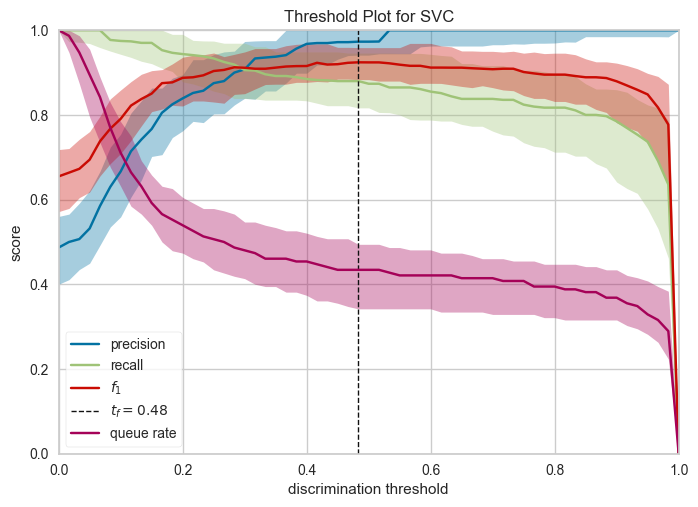

In [34]:
svc_lin2  = SVC(C=1.0, kernel='linear', probability=True, random_state=42)
fraud_detection_model_evaluation(svc_lin2, X_train, X_test, y_train, y_test, "coefficients", threshold_plot=True)

Algorithm: SVC

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        92
           1       0.96      0.95      0.95        97

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

Accuracy Score: 0.9523809523809523

Confusion Matrix:
 [[88  4]
 [ 5 92]]

Area under curve: 0.9905871806364859 



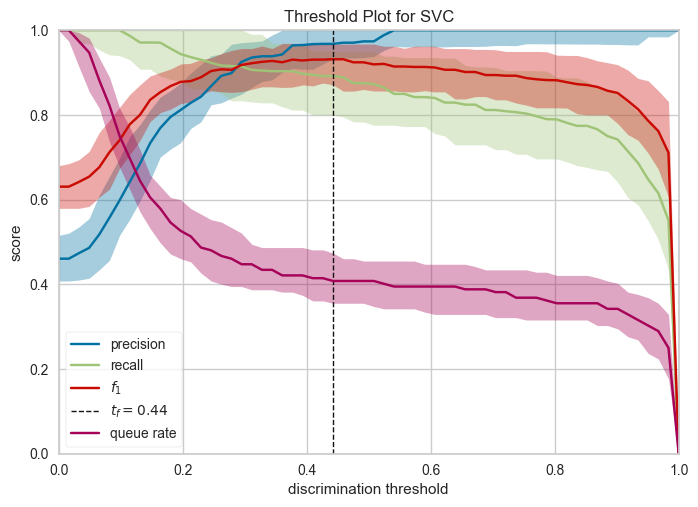

In [35]:
svc_lin3  = SVC(C=10.0, kernel='linear', probability=True, random_state=42)
fraud_detection_model_evaluation(svc_lin3, X_train, X_test, y_train, y_test, "coefficients", threshold_plot=True)

# Decision Tree Classifier

In [36]:
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG, display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

def treeplot(classifier, cols, classnames):
    #plot decision tree
    graph = Source(tree.export_graphviz(classifier, out_file=None, 
                                        rounded=True, proportion=False,
                                        feature_names = cols, 
                                        precision = 2,
                                        class_names = classnames,
                                        filled = True)
                  )
    display(graph)

Algorithm: DecisionTreeClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93        92
           1       0.93      0.95      0.94        97

    accuracy                           0.94       189
   macro avg       0.94      0.94      0.94       189
weighted avg       0.94      0.94      0.94       189

Accuracy Score: 0.9365079365079365

Confusion Matrix:
 [[85  7]
 [ 5 92]]

Area under curve: 0.9366875840430302 



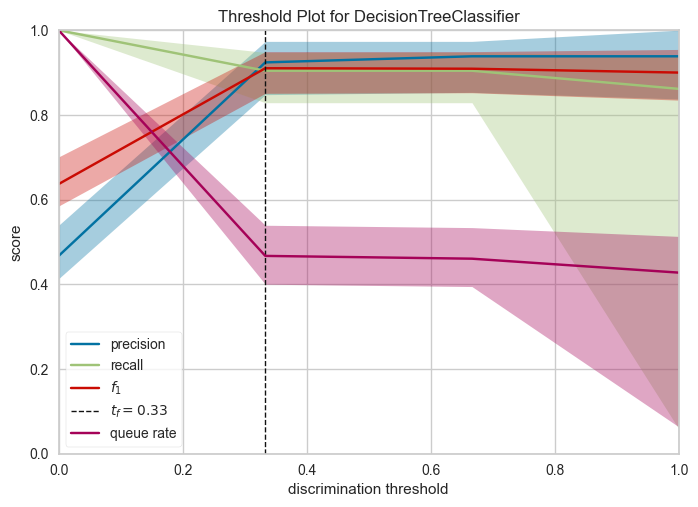

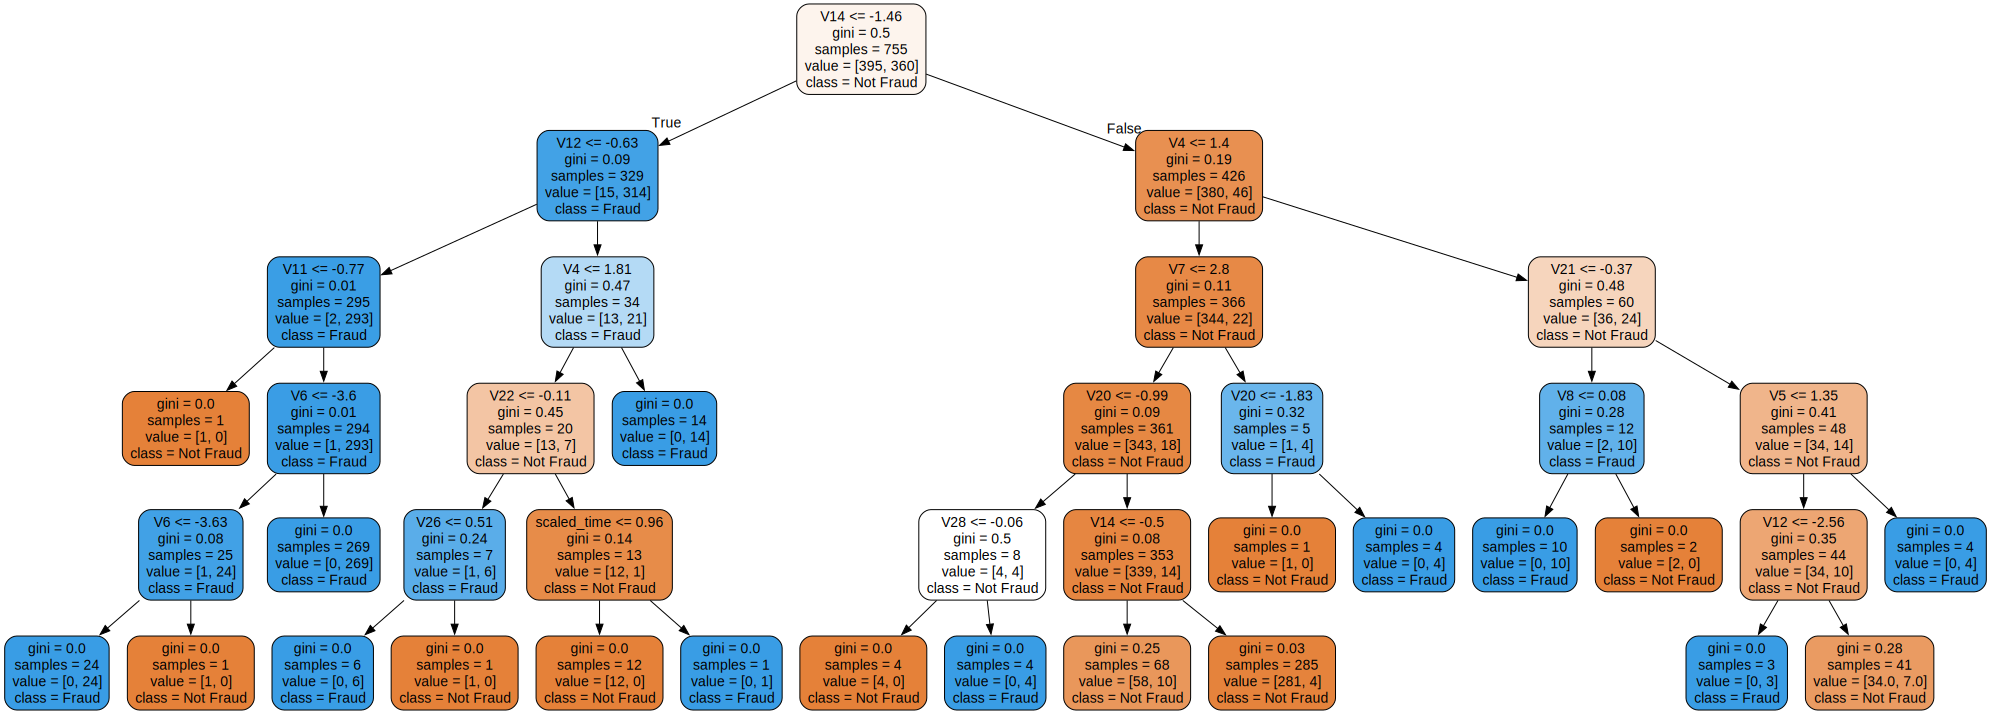

In [37]:
decision_tree1 = DecisionTreeClassifier(max_depth = 5)

fraud_detection_model_evaluation(decision_tree1, X_train, X_test, y_train, y_test, "features", threshold_plot=True)

#plot decision tree
treeplot(decision_tree1, cols, ["Not Fraud", "Fraud"])

Algorithm: DecisionTreeClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92        92
           1       0.90      0.95      0.92        97

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted avg       0.92      0.92      0.92       189

Accuracy Score: 0.9206349206349206

Confusion Matrix:
 [[82 10]
 [ 5 92]]

Area under curve: 0.9198789780367548 



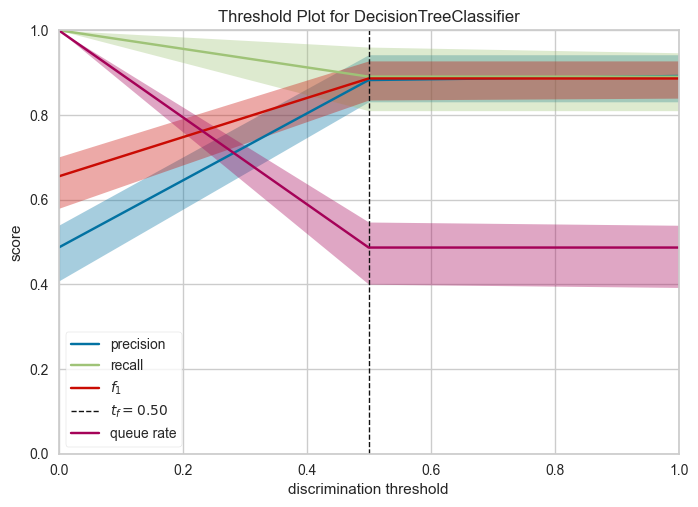

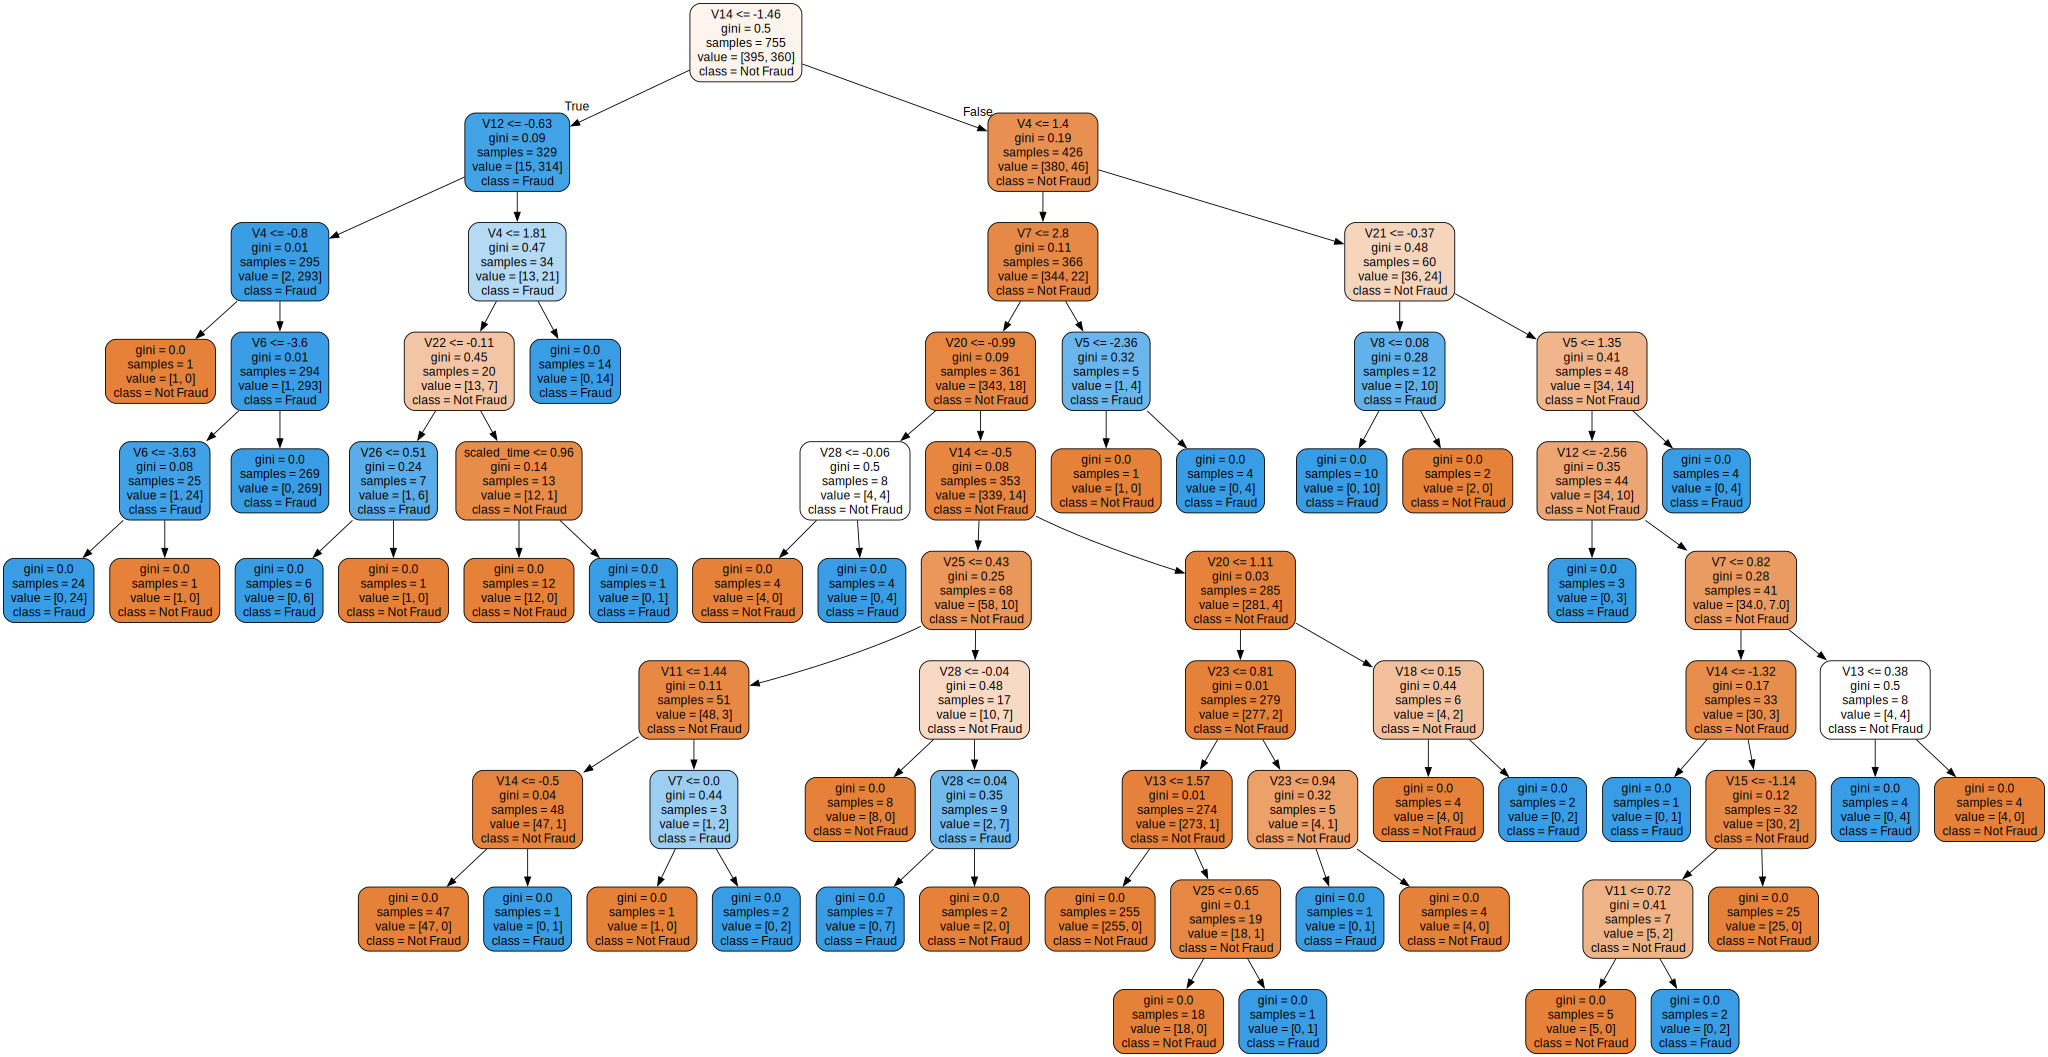

In [38]:
decision_tree2 = DecisionTreeClassifier(max_depth = 9)

fraud_detection_model_evaluation(decision_tree2, X_train, X_test, y_train, y_test, "features", threshold_plot=True)

#plot decision tree
treeplot(decision_tree2, cols, ["Not Fraud", "Fraud"])

Algorithm: DecisionTreeClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91        92
           1       0.89      0.96      0.92        97

    accuracy                           0.92       189
   macro avg       0.92      0.91      0.91       189
weighted avg       0.92      0.92      0.92       189

Accuracy Score: 0.9153439153439153

Confusion Matrix:
 [[80 12]
 [ 4 93]]

Area under curve: 0.9141640519946213 



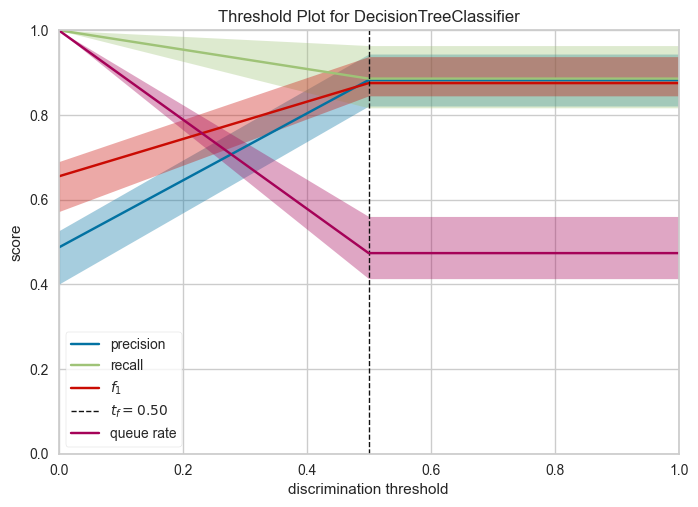

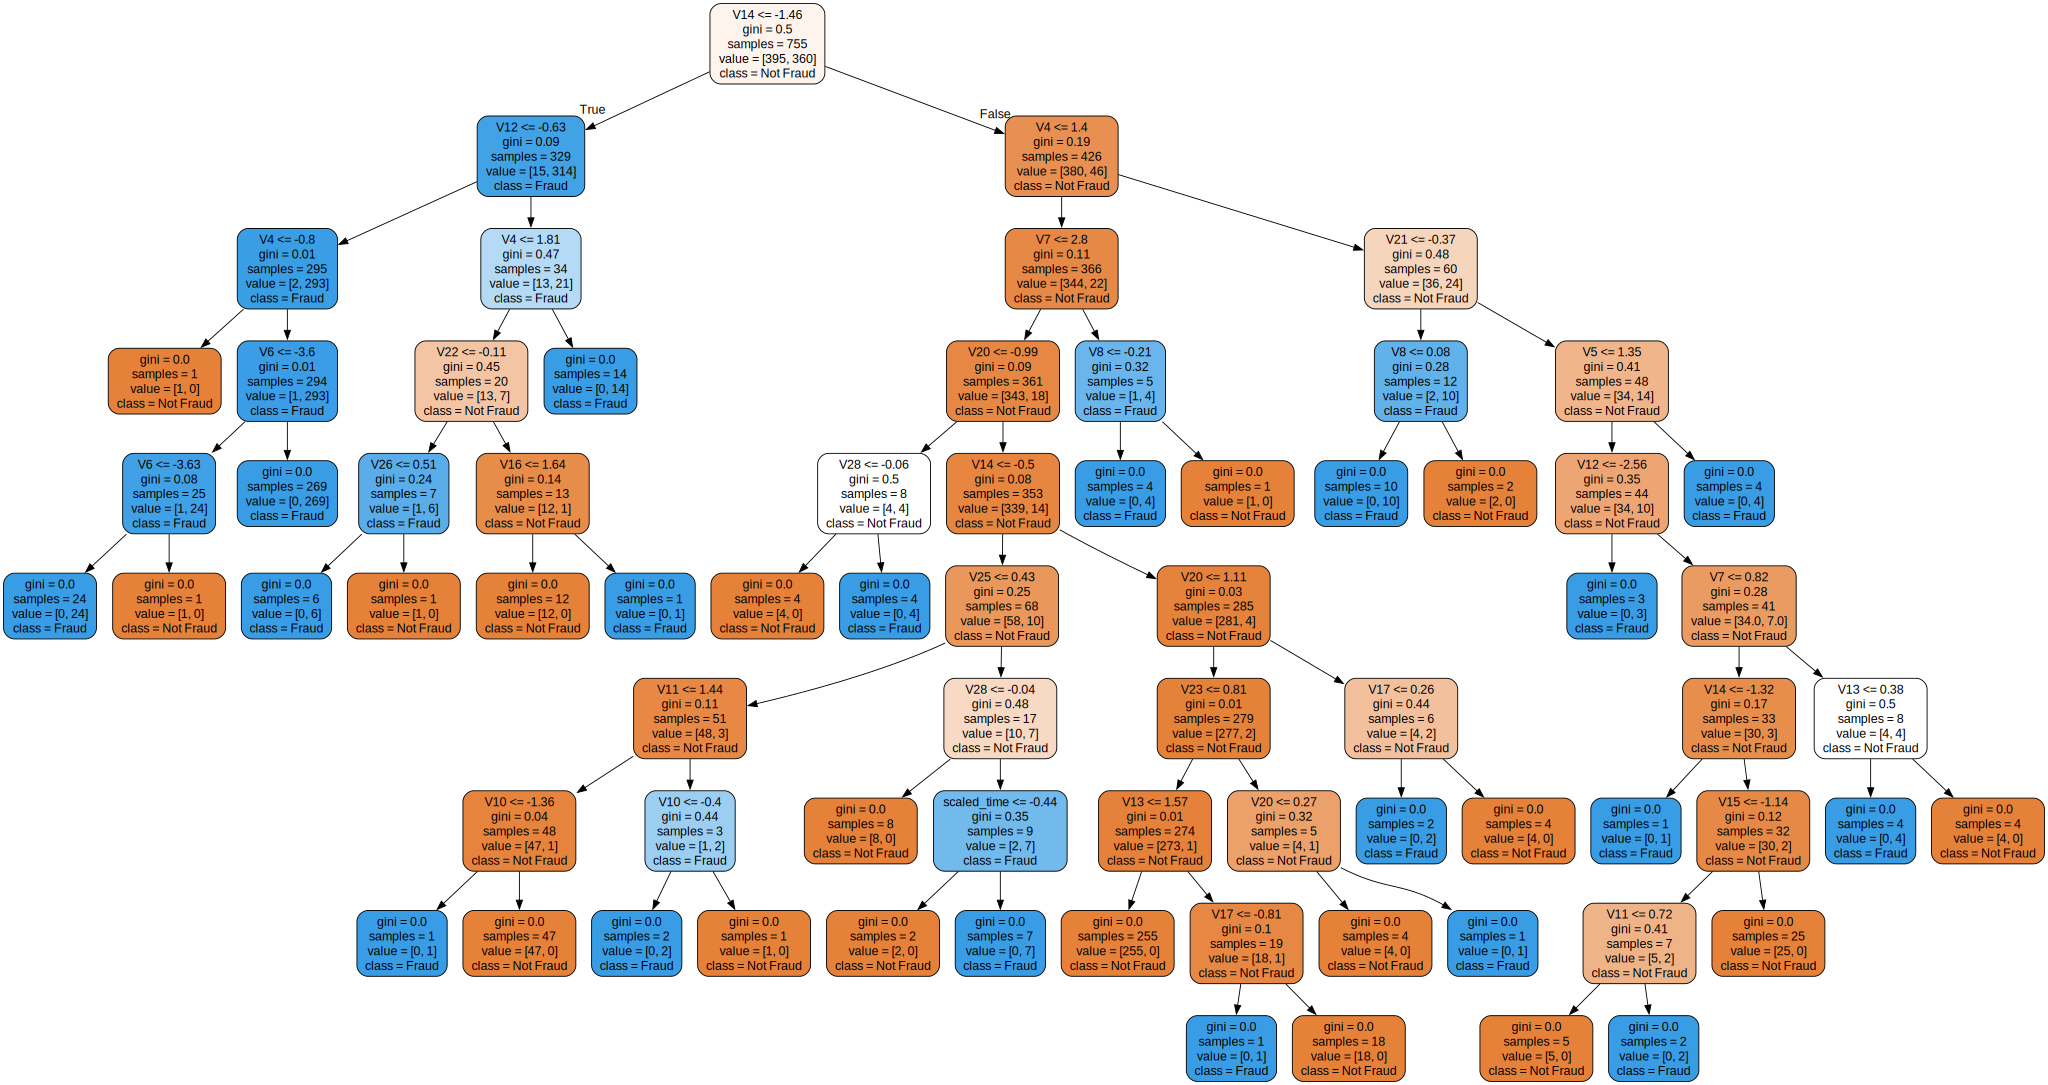

In [39]:
decision_tree3 = DecisionTreeClassifier(max_depth = None)

fraud_detection_model_evaluation(decision_tree3, X_train, X_test, y_train, y_test, "features", threshold_plot=True)

#plot decision tree
treeplot(decision_tree3, cols, ["Not Fraud", "Fraud"])

# Random Forest Classifier

Algorithm: RandomForestClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        92
           1       0.96      0.92      0.94        97

    accuracy                           0.94       189
   macro avg       0.94      0.94      0.94       189
weighted avg       0.94      0.94      0.94       189

Accuracy Score: 0.9365079365079365

Confusion Matrix:
 [[88  4]
 [ 8 89]]

Area under curve: 0.9837516808606006 



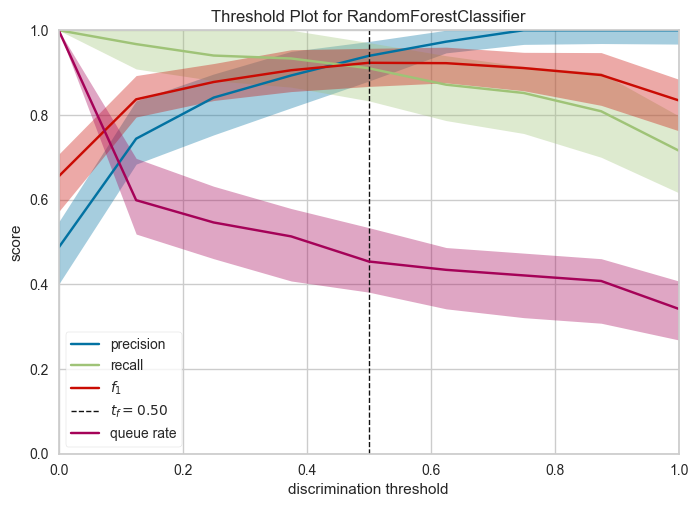

In [40]:
rfc1 = RandomForestClassifier(n_estimators=10)
fraud_detection_model_evaluation(rfc1, X_train, X_test, y_train, y_test, "features", threshold_plot=True)

Algorithm: RandomForestClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        92
           1       0.96      0.95      0.95        97

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

Accuracy Score: 0.9523809523809523

Confusion Matrix:
 [[88  4]
 [ 5 92]]

Area under curve: 0.9824069923800987 



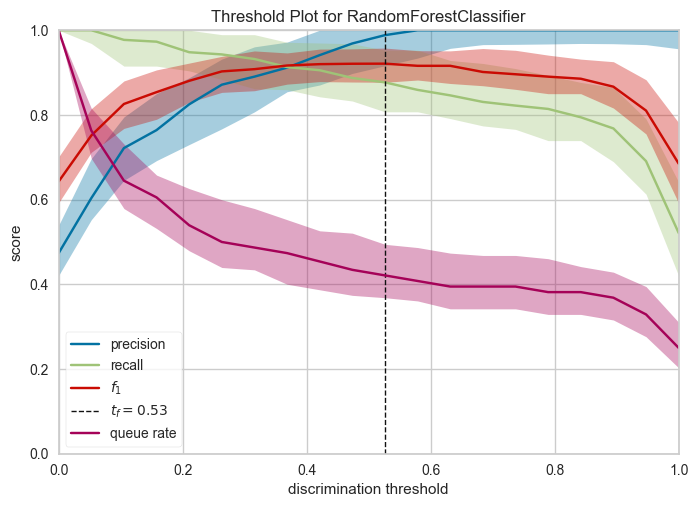

In [41]:
rfc2 = RandomForestClassifier(n_estimators = 50)
fraud_detection_model_evaluation(rfc2, X_train, X_test, y_train, y_test, "features", threshold_plot=True)

Algorithm: RandomForestClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        92
           1       0.95      0.95      0.95        97

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

Accuracy Score: 0.9470899470899471

Confusion Matrix:
 [[87  5]
 [ 5 92]]

Area under curve: 0.9861048857014793 



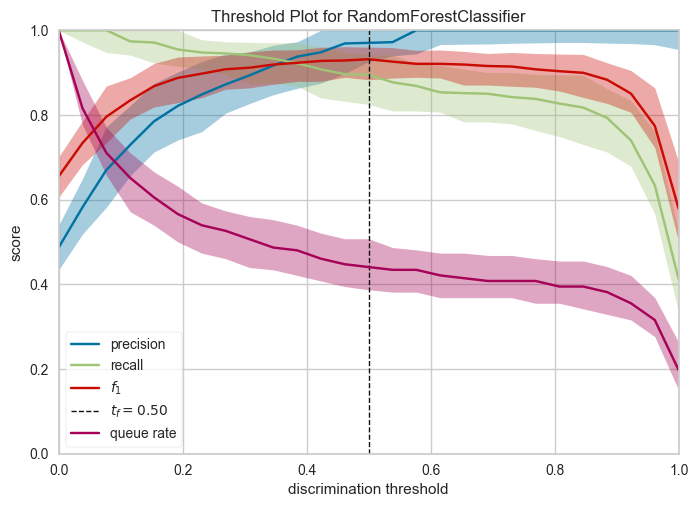

In [42]:
rfc3 = RandomForestClassifier(n_estimators = 100)
fraud_detection_model_evaluation(rfc3, X_train, X_test, y_train, y_test, "features", threshold_plot=True)

# XGBoost Classifier

Algorithm: XGBClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96        92
           1       0.96      0.97      0.96        97

    accuracy                           0.96       189
   macro avg       0.96      0.96      0.96       189
weighted avg       0.96      0.96      0.96       189

Accuracy Score: 0.9629629629629629

Confusion Matrix:
 [[88  4]
 [ 3 94]]

Area under curve: 0.9901389511429852 



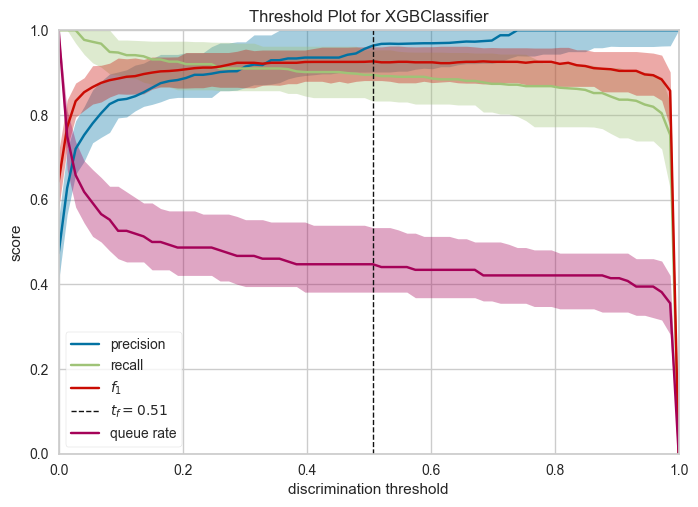

In [43]:
xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=float('nan'), n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
fraud_detection_model_evaluation(xgc, X_train, X_test, y_train, y_test, "features", threshold_plot=True)

# So sánh

### Hiệu suất các mô hình

In [44]:
#putting all the model names, model classes and the used columns in a dictionary
models = {'Logistic (C=0.01)': [logit1, cols],
          'Logistic (C=1)': [logit2, cols], 
          'Logistic (C=100)': [logit3, cols], 
          'KNN Classifier(neighbor=1)': [knn1, cols], 
          'KNN Classifier(neighbors=5)': [knn2, cols], 
          'KNN Classifier(neighbors=10)': [knn3, cols], 
          'SVC (C=0.1)': [svc_lin1, cols], 
          'SVC (C=1.0)': [svc_lin2, cols], 
          'SVC (C=10.0)': [svc_lin3, cols], 
          'Decision Tree(5)': [decision_tree1, cols], 
          'Decision Tree(9)': [decision_tree2, cols], 
          'Decision Tree(None)': [decision_tree3, cols], 
          'Random Forest(estimators=10)': [rfc1, cols], 
          'Random Forest(estimators=50)': [rfc2, cols], 
          'Random Forest(estimators=100)': [rfc3, cols], 
          'XGBoost Classifier': [xgc, cols], 
         }

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
def model_report(model, training_x, testing_x, training_y, testing_y, name):
    model = model.fit(training_x, training_y)
    predictions = model.predict(testing_x)
    accuracy = accuracy_score(testing_y, predictions)
    recallscore = recall_score(testing_y, predictions)
    precision = precision_score(testing_y, predictions)
    roc_auc = roc_auc_score(testing_y, predictions)
    f1score = f1_score(testing_y, predictions) 
    kappa_metric = cohen_kappa_score(testing_y, predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy"        : [accuracy],
                       "Recall"          : [recallscore],
                       "Precision"       : [precision],
                       "f1-score"        : [f1score],
                       "Roc_auc"         : [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

In [46]:
import plotly.figure_factory as ff
import plotly.offline as py
py.init_notebook_mode(connected=True)
model_performances_train = pd.DataFrame() 
for name in models:
    model_performances_train = model_performances_train._append(model_report(models[name][0], X_train[models[name][1]], X_test[models[name][1]], y_train, y_test, name), ignore_index=True)   
table_train = ff.create_table(np.round(model_performances_train, 4))
py.iplot(table_train)

### So sánh các mô hình

In [47]:
def output_tracer(df, metric, color):
    tracer = go.Bar(y = df["Model"],
                    x = df[metric],
                    orientation = "h", name = metric ,
                    marker = dict(line = dict(width =.7), color = color)
                   )
    return tracer

def modelmetricsplot(df, title):
    layout = go.Layout(dict(title = title,
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5, gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1, ticklen=5, gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )
    trace1 = output_tracer(df, "Accuracy", "#6699FF")
    trace2 = output_tracer(df, 'Recall', "red")
    trace3 = output_tracer(df, 'Precision', "#33CC99")
    trace4 = output_tracer(df, 'f1-score', "lightgrey")
    trace5 = output_tracer(df, 'Roc_auc', "magenta")
    trace6 = output_tracer(df, 'Kappa_metric', "#FFCC99")

    data = [trace1, trace2, trace3, trace4, trace5, trace6]
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [48]:
modelmetricsplot(df=model_performances_train, title="Model performances over the training dataset")

# Lưu trữ mô hình

In [49]:
import joblib

In [50]:
joblib.dump(xgc, 'model.joblib')

['model.joblib']

In [51]:
model = joblib.load('model.joblib')

In [53]:
pred = model.predict([[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])

In [54]:
if pred == 0:
    print("Genunine Transaction")
else:
    print("Fradulent Transaction")

Genunine Transaction
